# The Titanic Survivors Predictor

Would you survive if you was on board in the titanic ship that night :)

In [2]:
#import the required libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as  sns
# Preprocessing allows us to standarsize our data
from sklearn import preprocessing
# import the classification algorthims
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
# Allows us to test parameters of classification algorithms and find the best one
from sklearn.model_selection import GridSearchCV

In [3]:
train_data = pd.read_csv('train.csv')
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train_data.shape

(891, 12)

In [5]:
# quick check for training dataset
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

We can't consider the Cabin column because of the huge number of missing values
The Embarked and age columns need to be cleaned before modeling

In [6]:
# drop the Cabin column
train_data.drop(labels=['Cabin'], axis=1, inplace=True)
# drop the missing values in the Age column
train_data.dropna(inplace=True)
train_data[['Age', 'Embarked']].isnull().sum()

Age         0
Embarked    0
dtype: int64

In [7]:
train_data['Embarked'].value_counts()

S    554
C    130
Q     28
Name: Embarked, dtype: int64

In [8]:
# cheange all columns to numerical values
# start with the Embarked column
embarked_dummies = pd.get_dummies(train_data['Embarked'])
embarked_dummies.rename(columns={'C':'C-Embarked', 'Q':'Q-Embarked', 'S':'S-Embarked'}, inplace=True)

# merge train data with this Embarked data
train_data = pd.concat([train_data, embarked_dummies], axis=1)

# drop the Embarked column
train_data.drop('Embarked', axis=1, inplace=True)

train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,C-Embarked,Q-Embarked,S-Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,0,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,0,0,1


In [9]:
train_data['Sex'].value_counts()

male      453
female    259
Name: Sex, dtype: int64

In [10]:
# Similarly the Sex column
sex_dummies = pd.get_dummies(train_data['Sex'])
sex_dummies.rename(columns={'male': 'Sex-m', 'female': 'Sex-f'}, inplace=True)

# merge train data with this Sex data
train_data = pd.concat([train_data, sex_dummies], axis=1)

# drop the Embarked column
train_data.drop('Sex', axis=1, inplace=True)

train_data.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,C-Embarked,Q-Embarked,S-Embarked,Sex-f,Sex-m
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,0,0,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,1,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,0,0,1,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,0,0,1,1,0
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,0,0,1,0,1


Text(0.5, 1.0, 'Age bins')

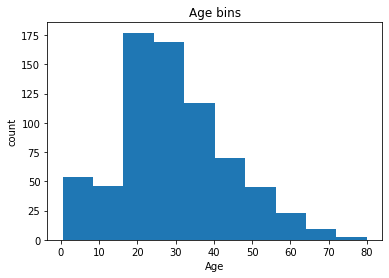

In [11]:
# For Age column we need to bin it first and then create dummies values
plt.hist(train_data['Age'])

# set x/y labels and plot title
plt.xlabel('Age')
plt.ylabel('count')
plt.title('Age bins')

In [12]:
#train_data['Age'].value_counts().index.max()
#train_data['Age'].value_counts().head(20)
train_data['Age'].value_counts()

24.00    30
22.00    27
18.00    26
19.00    25
28.00    25
         ..
36.50     1
55.50     1
0.92      1
23.50     1
74.00     1
Name: Age, Length: 88, dtype: int64

In [13]:
# divide into 3 bins using linspace function and 4 dividers
bins = np.array([0,16,40, 80])
group_names = ['young', 'adult', 'elder']
train_data['Age-binned'] = pd.cut(train_data['Age'], bins, labels=group_names, include_lowest=True )
train_data[['Age','Age-binned', 'Survived']].head()

,Age,Age-binned,Survived
0,22.0,adult,0
1,38.0,adult,1
2,26.0,adult,1
3,35.0,adult,1
4,35.0,adult,0


In [14]:
train_data['Age-binned'].value_counts()

adult    463
elder    149
young    100
Name: Age-binned, dtype: int64

Text(0.5, 1.0, 'Age bins')

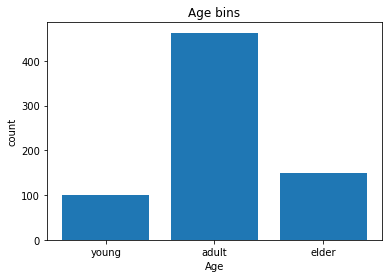

In [15]:
# For Age column after binning
plt.bar(group_names, train_data['Age-binned'].value_counts().sort_index())

# set x/y labels and plot title
plt.xlabel('Age')
plt.ylabel('count')
plt.title('Age bins')

In [16]:
# now time to create dummies values and try to find the correlation
# Similarly the Age column
age_dummies = pd.get_dummies(train_data['Age-binned'])
age_dummies.rename(columns={'young': 'Age-y', 'adult': 'Age-a', 'elder': 'Age-e'}, inplace=True)

# merge train data with this Agw data
train_data = pd.concat([train_data, age_dummies], axis=1)

# drop the Embarked column
train_data.drop(['Age','Age-binned'], axis=1, inplace=True)

train_data.head()

,PassengerId,Survived,Pclass,Name,SibSp,Parch,Ticket,Fare,C-Embarked,Q-Embarked,S-Embarked,Sex-f,Sex-m,Age-y,Age-a,Age-e
0,1,0,3,"Braund, Mr. Owen Harris",1,0,A/5 21171,7.2500,0,0,1,0,1,0,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,0,PC 17599,71.2833,1,0,0,1,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",0,0,STON/O2. 3101282,7.9250,0,0,1,1,0,0,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,0,113803,53.1000,0,0,1,1,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",0,0,373450,8.0500,0,0,1,0,1,0,1,0


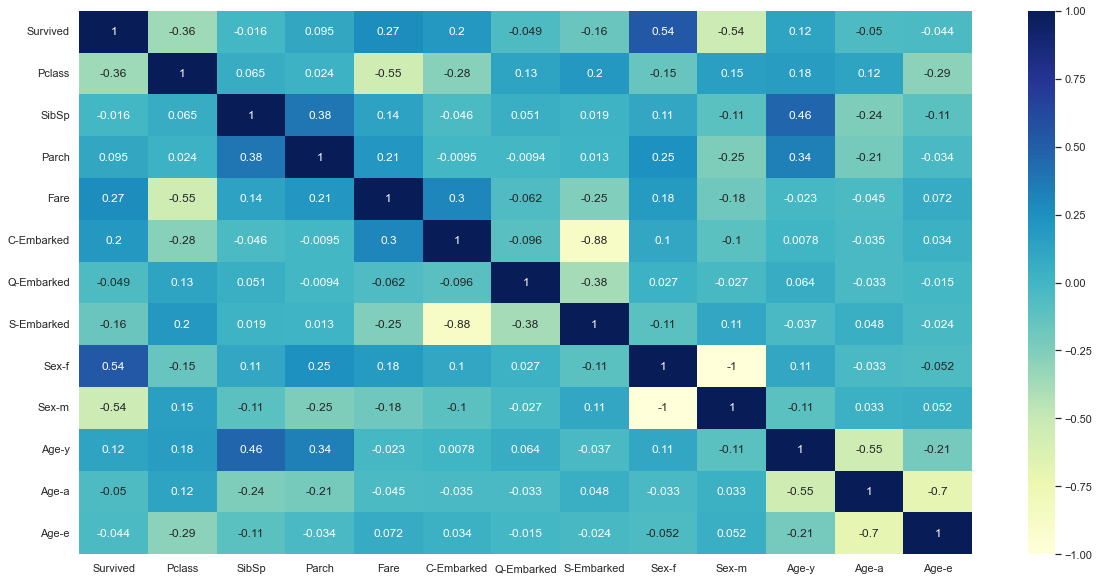

In [18]:
# choose the features required for prediction
features = ['Survived', 'Pclass', 'SibSp', 'Parch', 'Fare', 'C-Embarked', 'Q-Embarked', 'S-Embarked', 'Sex-f', 'Sex-m', 'Age-y', 'Age-a', 'Age-e']
# visualize survivals with respect to Age
sns.heatmap(train_data[features].corr(), cmap="YlGnBu", annot=True)
sns.set(rc={'figure.figsize':(20,10)})

#### change the test_data to match the trained data

In [19]:
test_data = pd.read_csv('test.csv')
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [20]:
# check missing values
test_data.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [22]:
#test_data['Age'].fillna(method='ffill', inplace=True)
#test_data['Fare'].value_counts()
#test_data['Fare'].fillna(7.7500, inplace=True)

In [23]:
# binning for the data for Age column in test data
test_data['Age-binned'] = pd.cut(test_data['Age'], bins, labels=group_names, include_lowest=True )
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age-binned
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,adult
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,elder
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,elder
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,adult
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,adult


In [24]:
y_features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Age-binned']
x_test = pd.get_dummies(test_data[y_features])
#x_test.head()
x_test.rename(columns={'Sex_female':'Sex-f', 'Sex_male':'Sex-m', 'Embarked_C':'C-Embarked', 'Embarked_Q':'Q-Embarked', 'Embarked_S':'S-Embarked', 'Age-binned_young':'Age-y', 'Age-binned_adult':'Age-a', 'Age-binned_elder':'Age-e'}, inplace=True)
x_test = preprocessing.StandardScaler().fit(x_test).transform(x_test)
x_test.shape

(418, 12)

I will try multiple methods of classification and evaluate them so the best will be saved

### Dicition tree

In [25]:
# get the training data the features
features = ['Pclass', 'SibSp', 'Parch', 'Fare', 'C-Embarked', 'Q-Embarked', 'S-Embarked', 'Sex-f', 'Sex-m', 'Age-y', 'Age-a', 'Age-e']
X = train_data[features]
X = preprocessing.StandardScaler().fit(X).transform(X)
X.shape

(712, 12)

In [26]:
Y = train_data['Survived']
Y.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [149]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()
tree_cv = GridSearchCV(tree, parameters, cv=10)
tree_cv.fit(X, Y)
print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'splitter': 'best'}
accuracy : 0.8175273865414712


In [150]:
# predict the result for test and save in csv file
prediction_tree = tree_cv.predict(x_test)
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': prediction_tree})
output.to_csv('submission_tree.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


### Logestic Regression

In [152]:
parameters ={"C":[0.01,0.1,1],'penalty':['l2'], 'solver':['lbfgs']}# l1 lasso l2 ridge
lr=LogisticRegression()
logreg_cv = GridSearchCV(lr, parameters, cv=10)
logreg_cv.fit(X, Y)
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.7894170579029735


In [153]:
# predict the result for test and save in csv file
prediction_logreg = logreg_cv.predict(x_test)
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': prediction_logreg})
output.to_csv('submission_logreg.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


### SVM classification

In [154]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC()
svm_cv = GridSearchCV(svm, parameters, cv=10)
svm_cv.fit(X, Y)
print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

In [ ]:
# predict the result for test and save in csv file
prediction_svm = svm_cv.predict(x_test)
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': prediction_svm})
output.to_csv('submission_svm.csv', index=False)
print("Your submission was successfully saved!")

### KNN classifier

In [27]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()
knn_cv = GridSearchCV(KNN, parameters, cv=10)
knn_cv.fit(X, Y)
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 6, 'p': 2}
accuracy : 0.8202856025039125


In [29]:
# predict the result for test and save in csv file
prediction_knn = knn_cv.predict(x_test)
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': prediction_knn})
output.to_csv('submission_knn.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
